In [1]:
import os, sys
import pytorch_lightning as pl
import torch
from rdkit import Chem
import numpy as np
import rdkit.Chem.Descriptors
sys.path.append("../../../")

First we start with a simple example by predicting the molar masses of random molecules (**maybe library for creating pseudo random molecules**). As a featurization the mass of each individual atom was used. As a result the model should be trained to simply add all individual atomic masses. 

Thus first we create the model without any graph convolutional layer and as a pooling function sum pooling is used:

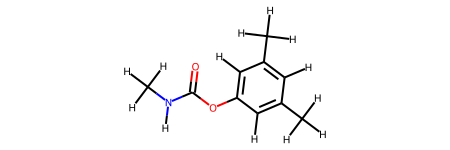

NameError: name 'Image' is not defined

In [2]:
from molNet.nn.models.graph_convolution import PoolSum
from molNet.dataloader.molecule_loader import PytorchGeomMolGraphFromGeneratorLoader,PytorchGeomMolGraphGenerator
from molNet.dataloader.datasets import DelaneySolubility
from molNet.featurizer.atom_featurizer import atom_mass

class SimpleSumAtomMassesModel(pl.LightningModule):
    def __init__(self,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.pooling =PoolSum()

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.pooling(feats, batch)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = torch.sum(torch.abs(y_hat-batch.y))
        result = pl.TrainResult(minimize=loss)#
        result.log('train_loss', loss, on_epoch=True)
        return result
        

# no parameter and thus no training necessary
model = SimpleSumAtomMassesModel()
dataloader=DelaneySolubility().to_pytorchgeo_molgraph_generator(
    to_graph_params = dict(with_properties=True,atom_featurizer=atom_mass,with_mol_graph=True),
    generator_params={"shuffle":False}
)

loader = PytorchGeomMolGraphFromGeneratorLoader(
    *dataloader,
    batch_size=1)
loader.setup()

max_data=len(loader.test_dataloader())-1
#max_data=20
test_smiles="COc1ccc([N+](=O)[O-])cc1"
test_data=None
for i,d in enumerate(loader.test_dataloader()):
    if d.string_data[0][0][1] == test_smiles:
        test_data=d
    #display(d.mol_graph[0].mol)
    #display(d.mol_graph[0])
    if i >= max_data:
        break
 #   print(i)
#    print(d.string_data[0][0])
#    print(d.string_data_titles)
#    break
display(d.mol_graph[0].mol)
Image(d.mol_graph[0].get_png())


This is actually no machine learning model, since there are no trainable parameters. Basicall only a sum over all features - atom masses in this case - is perfomed. Obviously the result matches the real mass of the underlying molecule

In [5]:
try:
    model = SimpleSumAtomMassesModel.load_from_checkpoint(os.path.join("models","SimpleSumAtomMassesModel","model.ckpt"),map_location=lambda storage, location: storage)
except FileNotFoundError:
    loader = PytorchGeomMolGraphFromGeneratorLoader(
    *[PytorchGeomMolGraphGenerator(atom_featurizer=atom_mass,generator=g)
     for g in dataloader],
    batch_size=64)
    
    model = SimpleSumAtomMassesModel()
    trainer = pl.Trainer(max_epochs=100000,gpus=torch.cuda.device_count())
    trainer.fit(model,loader)

TypeError: __init__() got an unexpected keyword argument 'atom_featurizer'

0